In [338]:
import torch
import pandas as pd

In [339]:
# Load train and test sets
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Displaying basic info
print(train_df.shape)
print(test_df.shape)
print(train_df.head())

(891, 12)
(418, 11)
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500

In [340]:
train_df.info()
# used to get an idea about missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [341]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [342]:
# We dont need cabin info and ticket number as they do not indicate anything about survival
# dropping from train and test
train_df.drop(columns=["Cabin"],inplace=True)
test_df.drop(columns=["Cabin"],inplace=True)


In [343]:
print("\nMissing values in training set:")
print(train_df.isnull().sum())


Missing values in training set:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         2
dtype: int64


In [344]:
test_df.isnull().sum()

PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Ticket          0
Fare            1
Embarked        0
dtype: int64

In [345]:
train_df["Embarked"].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

# Filling missing values
1) Embarked in train
2) fare in test
3) age in train
4) age in test

In [346]:
# Filling missing values

# For embarked most people are of class S so repleceing null value to S for train dataset
train_df["Embarked"].fillna("s",inplace=True)


C:\Users\aryan\AppData\Local\Temp\ipykernel_21932\2716160494.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df["Embarked"].fillna("s",inplace=True)


In [347]:
# corrected Fare 
test_df[~test_df["Fare"].apply(lambda x: isinstance(x, (int, float)))]
test_df["Fare"] = pd.to_numeric(test_df["Fare"], errors="coerce")
mean_fare_pclass_3 = test_df[test_df["Pclass"] == 3]["Fare"].mean()
test_df["Fare"] = test_df["Fare"].fillna(mean_fare_pclass_3)


### For corrected Age we use a ml model that predicts the age of the passenger using gender and Pclass

In [348]:
#Separate Rows with Missing and Non-Missing Age
with_age_df = train_df[train_df["Age"].notnull()]
null_age_df = train_df[train_df["Age"].isnull()]

In [349]:
# selecting features that age depends upon
features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked']

In [350]:
# Converting features to numeric data
from sklearn.preprocessing import LabelEncoder

df_combined = pd.concat([with_age_df, null_age_df], sort=False)
for col in ['Sex', 'Embarked']:
    le = LabelEncoder()
    df_combined[col] = le.fit_transform(df_combined[col].astype(str))


In [351]:
#Split Again After Encoding/transforming data
df_with_age = df_combined[df_combined['Age'].notnull()]
df_missing_age = df_combined[df_combined['Age'].isnull()]


In [352]:
# training model using RandomForestRegressor

from sklearn.ensemble import RandomForestRegressor

X_train = df_with_age[features]
y_train = df_with_age['Age']

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [353]:
# Making predictions
X_missing = df_missing_age[features]
predicted_ages = model.predict(X_missing)

X_missing = df_missing_age[features]
predicted_ages = model.predict(X_missing)

# Fill the predicted ages back
train_df.loc[train_df['Age'].isnull(), 'Age'] = predicted_ages



In [354]:
# now doing the same for the test
df_with_age_test = test_df[test_df["Age"].notnull()]
df_missing_age_test = test_df[test_df["Age"].isnull()]

In [355]:
# Transforming our data
df_combined_test = pd.concat([df_with_age_test, df_missing_age_test], sort=False)
for col in ['Sex', 'Embarked']:
    le = LabelEncoder()
    df_combined_test[col] = le.fit_transform(df_combined_test[col].astype(str))

In [356]:
#Split Again After Encoding/transforming data
df_with_age_test = df_combined_test[df_combined_test['Age'].notnull()]
df_missing_age_test = df_combined_test[df_combined_test['Age'].isnull()]

In [357]:
# training model using RandomForestRegressor

from sklearn.ensemble import RandomForestRegressor

X_test = df_with_age_test[features]
y_test = df_with_age_test['Age']

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_test, y_test)

RandomForestRegressor(random_state=42)

In [358]:
# Making predictions
X_missing = df_missing_age_test[features]
predicted_ages = model.predict(X_missing)

X_missing = df_missing_age_test[features]
predicted_ages = model.predict(X_missing)

# Fill the predicted ages back
test_df.loc[test_df['Age'].isnull(), 'Age'] = predicted_ages

In [359]:
train_df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [360]:
test_df.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

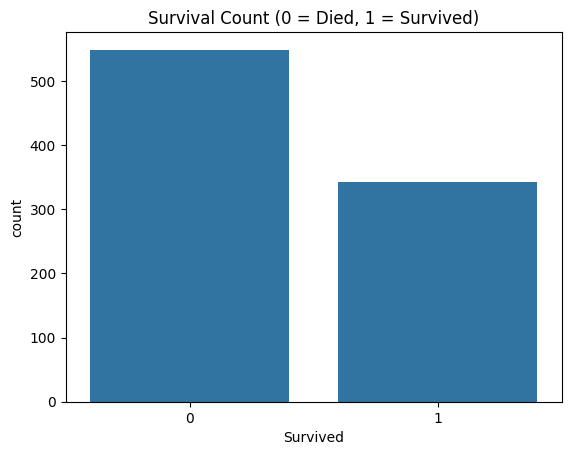

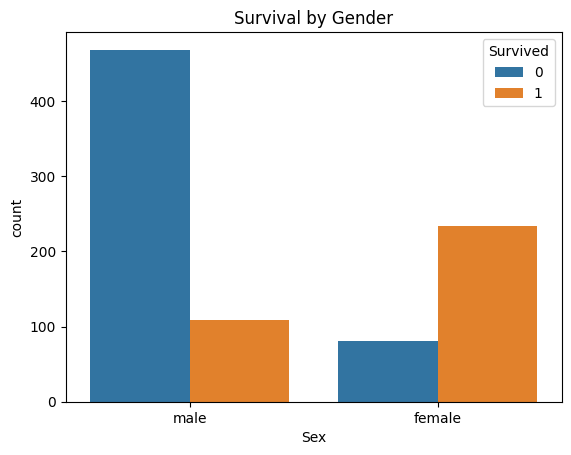

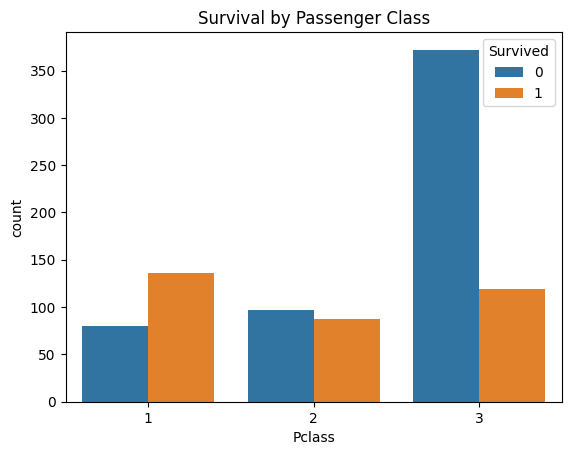

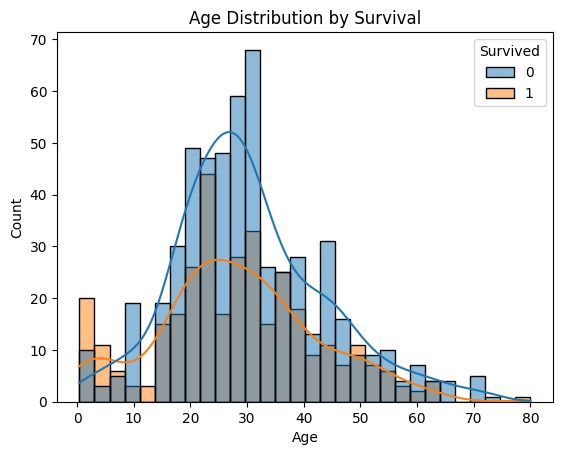

In [361]:
import seaborn as sns 
import matplotlib.pyplot as plt

# Plot survival count
sns.countplot(x='Survived', data=train_df)
plt.title("Survival Count (0 = Died, 1 = Survived)")
plt.show()

# Plot survival by Sex
sns.countplot(x='Sex', hue='Survived', data=train_df)
plt.title("Survival by Gender")
plt.show()

# Survival by Pclass
sns.countplot(x='Pclass', hue='Survived', data=train_df)
plt.title("Survival by Passenger Class")
plt.show()

# Plot Age distribution with survival overlay
sns.histplot(data=train_df, x="Age", bins=30, hue="Survived", kde=True)
plt.title("Age Distribution by Survival")
plt.show()


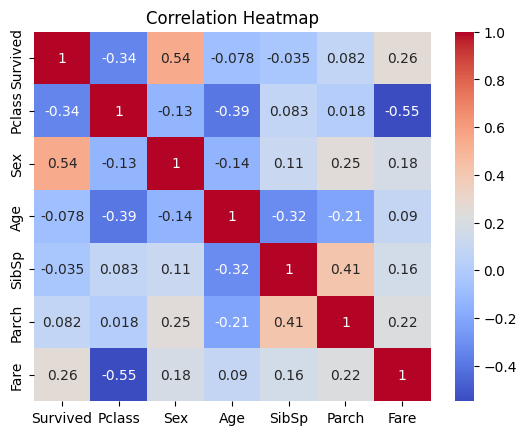

In [362]:
# Convert categorical 'Sex' to numeric for correlation
df_corr = train_df.copy()
df_corr['Sex'] = df_corr['Sex'].map({'male': 0, 'female': 1})
corr = df_corr[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [363]:
# We can remove ticket, name
train_df.drop(columns=["Ticket"],inplace=True)
test_df.drop(columns=["Ticket"],inplace=True)


In [364]:
train_df.drop(columns=["Name"],inplace=True)
test_df.drop(columns=["Name"],inplace=True)

In [365]:
# Combining Parch and SibSp since they hold same effect on survivability
train_df["family"] = train_df["SibSp"] + train_df["Parch"] + 1

In [366]:
test_df["family"] = test_df["SibSp"] + test_df["Parch"] + 1

In [367]:
train_df["family"].value_counts()

family
1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: count, dtype: int64

In [368]:
test_df["family"].value_counts()

family
1     253
2      74
3      57
4      14
5       7
11      4
7       4
6       3
8       2
Name: count, dtype: int64

In [369]:
train_df.groupby(["family"])["Survived"].mean()

family
1     0.303538
2     0.552795
3     0.578431
4     0.724138
5     0.200000
6     0.136364
7     0.333333
8     0.000000
11    0.000000
Name: Survived, dtype: float64

In [370]:
def cal(number):
    if number == 1:
        return "Alone"
    elif 2 <= number < 5:
        return "Medium"
    else:
        return "Large"


In [371]:
train_df['family_group'] = train_df['family'].apply(cal)


In [372]:
test_df['family_group'] = test_df['family'].apply(cal)

In [373]:
# dropping the 3 now unused column which are now combined
train_df.drop(columns=["SibSp","Parch","family"],inplace=True)
test_df.drop(columns=["SibSp","Parch","family"],inplace=True)

In [374]:
print(train_df.shape)
print(test_df.shape)
# To see if columns are removed or not

(891, 8)
(418, 7)


In [375]:
# string PassengerId and removing it as well
passengerId = test_df["PassengerId"].values

In [376]:
train_df.drop(columns=["PassengerId"],inplace=True)
test_df.drop(columns=["PassengerId"],inplace=True)

In [377]:
train_df.isnull().sum()

Survived        0
Pclass          0
Sex             0
Age             0
Fare            0
Embarked        0
family_group    0
dtype: int64

In [378]:
train_df['Embarked'] = train_df['Embarked'].str.upper()


In [379]:
train=pd.get_dummies(train_df, columns=["Pclass","Sex","Embarked","family_group"],drop_first=True)

In [380]:
test = pd.get_dummies(test_df, columns=["Pclass","Sex","Embarked","family_group"],drop_first=True)

In [381]:
train

,Survived,Age,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,family_group_Large,family_group_Medium
0,0,22.000000,7.2500,False,True,True,False,True,False,True
1,1,38.000000,71.2833,False,False,False,False,False,False,True
2,1,26.000000,7.9250,False,True,False,False,True,False,False
3,1,35.000000,53.1000,False,False,False,False,True,False,True
4,0,35.000000,8.0500,False,True,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...
886,0,27.000000,13.0000,True,False,True,False,True,False,False
887,1,19.000000,30.0000,False,False,False,False,True,False,False
888,0,17.144333,23.4500,False,True,False,False,True,False,True
889,1,26.000000,30.0000,False,False,True,False,False,False,False


In [382]:
test

,Age,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,family_group_Large,family_group_Medium
0,34.500000,7.8292,False,True,True,True,False,False,False
1,47.000000,7.0000,False,True,False,False,True,False,True
2,62.000000,9.6875,True,False,True,True,False,False,False
3,27.000000,8.6625,False,True,True,False,True,False,False
4,22.000000,12.2875,False,True,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...
413,26.370706,8.0500,False,True,True,False,True,False,False
414,39.000000,108.9000,False,False,False,False,False,False,False
415,38.500000,7.2500,False,True,True,False,True,False,False
416,26.370706,8.0500,False,True,True,False,True,False,False


In [ ]:
# 1. Create dummy-encoded version
processed_df = pd.get_dummies(train_df, columns=["Pclass", "Sex", "Embarked", "family_group"], drop_first=True)

# 2. Define features and labels
X = processed_df.drop("Survived", axis=1)
y = processed_df["Survived"]

# 3. Train-test split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Train the model
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train) 


RandomForestClassifier(random_state=42)

In [389]:
test_df_encoded = pd.get_dummies(test_df, columns=["Pclass", "Sex", "Embarked", "family_group"], drop_first=True)

In [390]:
X_test = test_df_encoded.reindex(columns=X.columns, fill_value=0)
predictions = model.predict(X_test)

In [384]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.8379888268156425


In [392]:
submission = pd.DataFrame({
    "PassengerId": passengerId,
    "Survived": predictions.astype(int)
})

submission.to_csv("submission.csv", index=False)
print("✅ submission.csv is ready for upload to Kaggle!")


✅ submission.csv is ready for upload to Kaggle!
